In [1]:
import numpy as np
import sys
sys.path.insert(1,'/home/zhanibek/.local/lib/python2.7/site-packages/cv2')
sys.path.insert(1,'/home/zhanibek/catkin_ws/src/smart_tray/scripts/')
import cv2 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook
import pickle
import pandas as pd
from phri.utils import *
from tqdm.notebook import tqdm

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets


## Functions

## Constants

In [2]:
meta_data_paths = [
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_sanket/trial_0/koh_sanket_trial_0_2020-10-11-20-48-27_meta_data_aruco_offline.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_zhanibek/trial_0/koh_zhanibek_trial_0_2020-10-11-21-19-07_meta_data_aruco_offline.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_0/trial_0_2020-10-12-14-47-43_meta_data_aruco_offline.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_1/trial_1_2020-10-12-14-51-53_meta_data_aruco_offline.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_sanket/trial_0/trial_0_2020-10-12-15-02-32_meta_data_aruco_offline.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_vignesh/trial_0/trial_0_2020-10-12-14-57-11_meta_data_aruco_offline.pkl'
]

ft_data_paths = [
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_sanket/trial_0/koh_sanket_trial_0_2020-10-11-20-48-27_meta_data_force_only.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_zhanibek/trial_0/koh_zhanibek_trial_0_2020-10-11-21-19-07_meta_data_force_only.pkl'
]

ann_paths = ['annotation - KOH_Sanket.csv','annotation - KOH_Zhanibek.csv']

ipath = 1
meta_data_path = meta_data_paths[ipath]
ft_data_path = ft_data_paths[ipath]
ann_path = ann_paths[ipath]

In [3]:
meta_data = pickle.load(open(meta_data_path))

In [4]:
ft_data = pickle.load(open(ft_data_path))

In [16]:
all_observations = pickle.load(open('segmented_trials.pkl'))

In [6]:
ann_df0 = pd.read_csv(ann_path)
ann_df0.columns = ['obs_num', 'trajectory_type', 'motion_type', 'negotiation', 't0_cam_1_seq',
                  't0_sec', 'tf_cam_1_seq', 'tf_sec', 'duration', 't0_precise','tf_precise',
                  'duration_precise']

time_offset = float(ann_df0['t0_sec'][0])*1000
time_offset

1602469000.0

In [7]:
ann_df = ann_df0[5:]
ann_df

,obs_num,trajectory_type,motion_type,negotiation,t0_cam_1_seq,t0_sec,tf_cam_1_seq,tf_sec,duration,t0_precise,tf_precise,duration_precise
5,1.0,AB1,serial,NaN,92450,1602469200,92741,1602469210,10,199.2581,209.7142,10.4561
6,2.0,BA2,serial,NaN,92905,1602469214,93272,1602469226,12,213.5372,226.8237,13.2865
7,3.0,AB2,parallel,NaN,93419,231,93632,238,7,229.8808,238.5025,8.6217
8,4.0,BA1,serial,NaN,93839,243,94106,252,9,242.8508,251.9875,9.1367
9,5.0,AB1,serial,NaN,94183,254,94476,263,9,254.2115,263.4201,9.2086
10,6.0,BA2,parallel,NaN,94658,268,94947,278,10,267.3638,278.1588,10.795
11,7.0,AB1,serial,NaN,95105,282,95352,290,8,281.568,290.6381,9.0701
12,8.0,BA2,serial,NaN,95510,295,95799,304,9,294.0758,303.9559,9.8801
13,9.0,AB1,serial,NaN,95963,309,96295,319,10,308.7495,318.8996,10.1501
14,10.0,BA1,parallel,NaN,96457,324,96817,335,11,323.2601,336.0401,12.78


In [8]:
def read_rft(tt0,ttf, temp_df):
    
    cut = temp_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = temp_df[cut]

    force =  dict(temp)['force'].to_numpy()
    force = np.array([[f[0],f[1],f[2]] for f in force])

    torque =  dict(temp)['torque'].to_numpy()
    torque = np.array([[f[0],f[1],f[2]] for f in torque])
    
    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tsteps[0]
    frame_id = temp_df.frame_id.iloc[0]
    
    new_force = np.zeros(force.shape)
    new_torque = new_force.copy()
    # Sensor 1
    if frame_id =='C00300119':        
        new_force[:,0] = force[:,2]
        new_force[:,1] = force[:,0]
        new_force[:,2] = force[:,1]
        
        new_torque[:,0] = torque[:,2]
        new_torque[:,1] = torque[:,0]
        new_torque[:,2] = torque[:,1]
    # Sensor 2    
    elif frame_id =='C00300122':
        new_force[:,0] = -force[:,2]
        new_force[:,1] = -force[:,0]
        new_force[:,2] = force[:,1]
        
        new_torque[:,0] = -torque[:,2]
        new_torque[:,1] = -torque[:,0]
        new_torque[:,2] = torque[:,1]
        
    res = {'time_steps': tsteps, 'force': new_force, 'torque':new_torque, 'frame_id':frame_id }
    
    return res

def read_imu(tt0, ttf, temp_df):

    cut = imu_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = imu_df[cut]

    accel =  dict(temp)['accel'].to_numpy()
    accel = np.array([[f[0],f[1],f[2]] for f in accel])

    gyro =  dict(temp)['gyro'].to_numpy()
    gyro = np.array([[f[0],f[1],f[2]] for f in gyro])

    mag =  dict(temp)['mag'].to_numpy()
    mag = np.array([[f[0],f[1],f[2]] for f in mag])
    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tsteps[0]
    
    
    new_accel = np.zeros(accel.shape)
    new_gyro = new_accel.copy()
    new_mag = new_gyro.copy()
       
    new_accel[:,0] = accel[:,0]
    new_accel[:,1] = -accel[:,1]
    new_accel[:,2] = -accel[:,2]

    new_mag[:,0] = mag[:,0]
    new_mag[:,1] = -mag[:,1]
    new_mag[:,2] = -mag[:,2]
    
    new_gyro[:,0] = gyro[:,0]
    new_gyro[:,1] = -gyro[:,1]
    new_gyro[:,2] = -gyro[:,2]
    
    res = {'time_steps': tsteps, 'accel': new_accel, 'gyro':new_gyro, 'mag':new_mag, 'frame_id': temp_df.frame_id.iloc[0]}

    return res

In [9]:
total_obs = ann_df.shape[0]
observations = []
rft1_df = ft_data['/RFT_FORCE']
rft2_df = ft_data['/RFT_FORCE_2']
imu_df = meta_data['/imu_data']

for obs_num in tqdm(range(1,total_obs+1)):

    tt0 = float(ann_df.t0_precise[ann_df.obs_num==obs_num])+time_offset
    ttf = float(ann_df.tf_precise[ann_df.obs_num==obs_num])+time_offset
    
    rft1 = read_rft(tt0,ttf, rft1_df)
    rft2 = read_rft(tt0,ttf, rft2_df)
    
    imu = read_imu(tt0, ttf, imu_df)
    
    
    traj_type = ann_df.trajectory_type[ann_df.obs_num==obs_num].iloc[0]
    motion_type = ann_df.motion_type[ann_df.obs_num==obs_num].iloc[0]
    
    obs = {'rft1': rft1, 'rft2': rft2, 'imu':imu, 'traj_type':traj_type, 'motion_type': motion_type}
    
    
    observations.append(obs)

In [10]:
obs = observations[10]

AB1 parallel


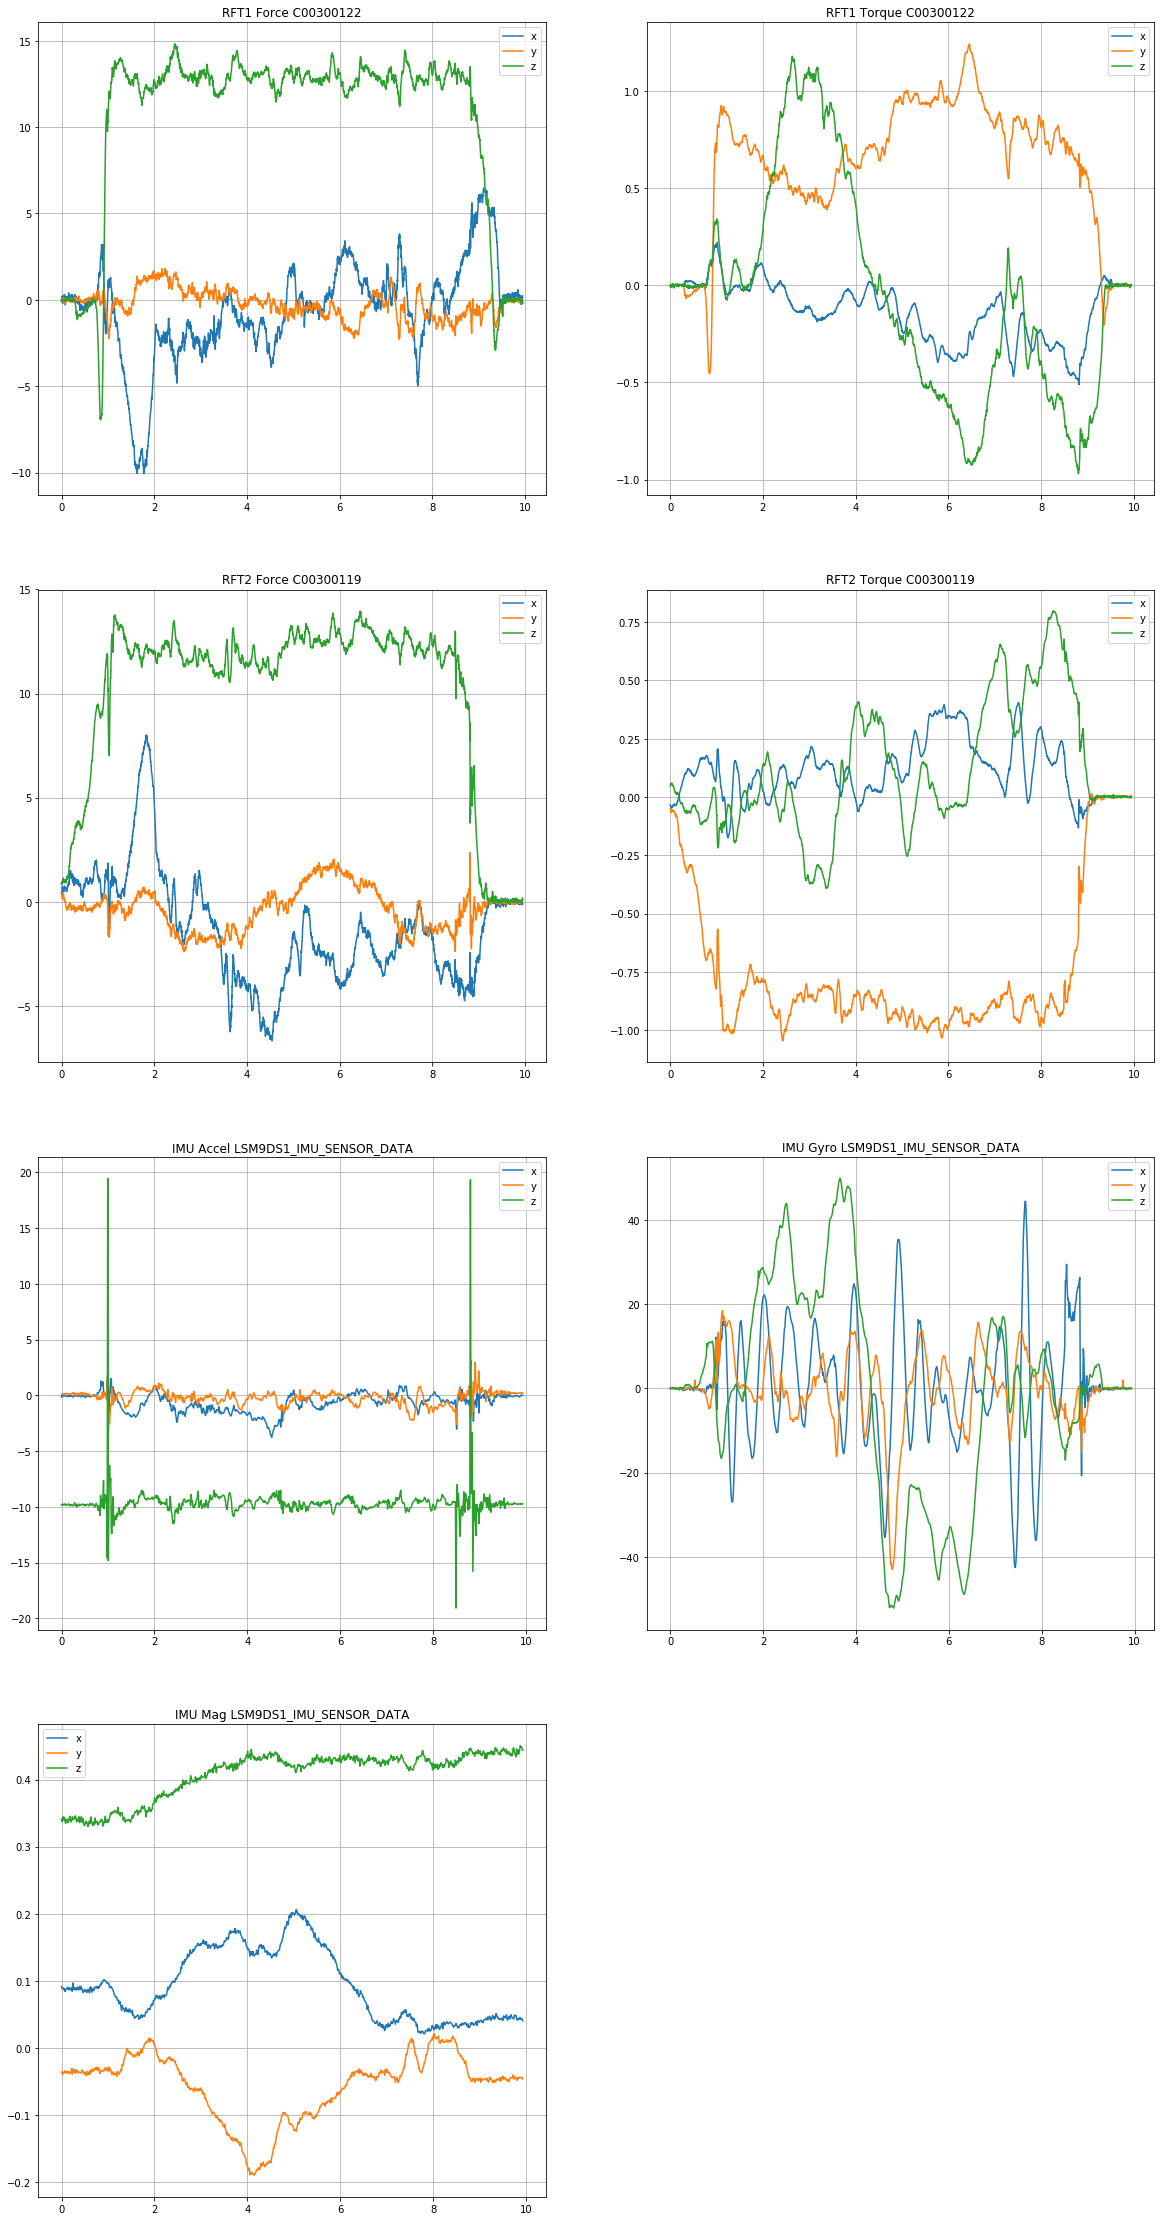

In [11]:
plt.figure(figsize=(20,40))
           
print obs['traj_type'], obs['motion_type']

# plt.title('{} {}'.format(obs['traj_type'],obs['motion_type']))

plt.subplot(4,2,1)
plt.plot(obs['rft1']['time_steps'], obs['rft1']['force'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT1 Force %s'%obs['rft1']['frame_id'])
plt.grid()

plt.subplot(4,2,2)
plt.plot(obs['rft1']['time_steps'], obs['rft1']['torque'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT1 Torque %s'%obs['rft1']['frame_id'])
plt.grid()

plt.subplot(4,2,3)
plt.plot(obs['rft2']['time_steps'], obs['rft2']['force'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT2 Force %s'%obs['rft2']['frame_id'])
plt.grid()


plt.subplot(4,2,4)
plt.plot(obs['rft2']['time_steps'], obs['rft2']['torque'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT2 Torque %s'%obs['rft2']['frame_id'])
plt.grid()


plt.subplot(4,2,5)
plt.plot(obs['imu']['time_steps'], obs['imu']['accel'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Accel %s'%obs['imu']['frame_id'])
plt.grid()


plt.subplot(4,2,6)
plt.plot(obs['imu']['time_steps'], obs['imu']['gyro'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Gyro %s'%obs['imu']['frame_id'])
plt.grid()

plt.subplot(4,2,7)
plt.plot(obs['imu']['time_steps'], obs['imu']['mag'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Mag %s'%obs['imu']['frame_id'])
plt.grid()






In [19]:
len(observations), len(all_observations)

(20, 38)

In [18]:
# all_observations = all_observations+observations

In [20]:
# pickle.dump(all_observations, open('segmented_trials.pkl', 'w'))